# colab.research.google.com/github/

# 전이학습 
- 고양이 강아지 구분 예
- VGG16와 Xception 모델을 사용한다
 - 각각 (224, 224), (299, 299)를 기본 입력으로 사용한다
 - 이미지넷으로 사전 훈련된 네트워크를 사용
 - 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 이진 분류에 사용  

- 1) 분류기만 학습시키는 방법
 - 특성 추출부분 즉, 합성곱 필터링 영역(convolutional base)은 그대로 사용
 - 분류기(전결합망) 부분의 파라미터만 고양이/강아지 데이터로 학습시킨다
- 2) 미세 조정 방식
 - 합성곱 필터링 영역의 일부 (상단)을 미세조정(fine tuning) 시키는 방법


# import

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import os, os.path, shutil
import zipfile
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception

from keras import layers
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
from tensorflow.keras import optimizers

# 데이터

In [2]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0   107M      0 --:--:-- --:--:-- --:--:--  107M


In [3]:
!unzip -oq cats_and_dogs_filtered.zip

In [4]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_dir

'./cats_and_dogs_filtered/train'

# 1) 분류기만 학습시키는 방법
 - 합성곱 필터링 영역(convolutional base)은 그대로 사용
 - 분류기(전결합망) 부분은 고양이/강아지 데이터로 학습시킨다

## VGG16 모델 가져오기
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

In [5]:
# conv_base = VGG16(weights = 'imagenet',
#                  include_top=False,
#                  input_shape=(150, 150, 3))

image_size = 299
conv_base = Xception(weights = 'imagenet',
                 include_top=False,
                 input_shape=(image_size, image_size, 3))
conv_base.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

## 모델 정의

In [6]:
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## 학습을 동결하지 않으면 모두 재 학습된다!

In [7]:
conv_base.trainable = False

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 47,076,137
Trainable params: 26,214,657
Non-trainable params: 20,861,480
_________________________________________________________________


In [9]:
# 데이터 증식

train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(image_size,image_size),
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(image_size,image_size),
											   class_mode='binary',
											   batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

history = model.fit_generator(
    generator=train_generator, 
    epochs=30,
    callbacks=callbacks_list,
    validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/30
100/100 [==============================] - 61s 484ms/step - loss: 1.8999 - accuracy: 0.9435 - val_loss: 0.7351 - val_accuracy: 0.9590
Epoch 2/30
100/100 [==============================] - 48s 482ms/step - loss: 0.4655 - accuracy: 0.9730 - val_loss: 0.2141 - val_accuracy: 0.9920
Epoch 3/30
100/100 [==============================] - 47s 472ms/step - loss: 0.1773 - accuracy: 0.9780 - val_loss: 0.0817 - val_accuracy: 0.9920
Epoch 4/30
100/100 [==============================] - 51s 512ms/step - loss: 0.1463 - accuracy: 0.9805 - val_loss: 0.1606 - val_accuracy: 0.9890
Epoch 5/30
100/100 [==============================] - 47s 472ms/step - loss: 0.2340 - accuracy: 0.9795 - val_loss: 0.0677 - val_accuracy: 0.9910


## 성능 확인

In [ ]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

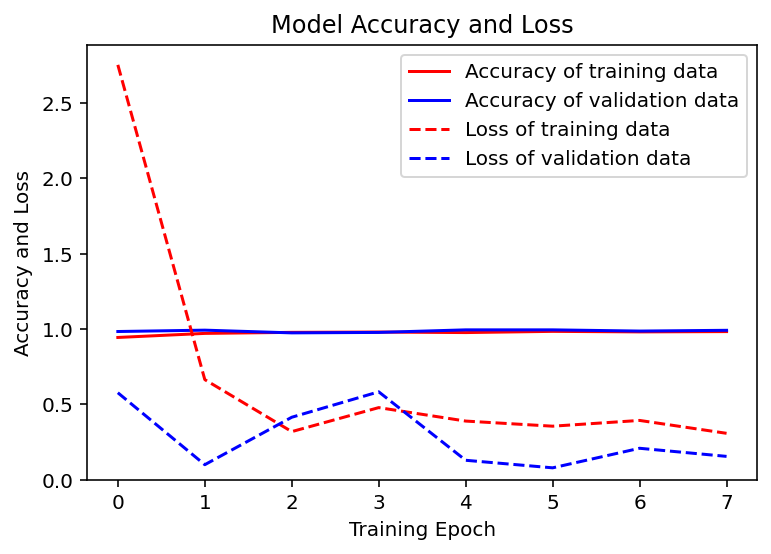

In [ ]:
show_4_graphs(history)

## 2) 미세조정 방법
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)

         

In [ ]:
conv_base.summary()

### 상위의 일부 블록만 미세조정 하겠다 (동결을 풀어야 한다)

In [ ]:
# 일단 모든 동결을 푼다
# VGG 16에서는 block5_conv1 이후의 블록을 푼다
# Xception에서는 block14_sepconv1 이후의 블록을 푼다

conv_base.trainable = True

FLAG = False
for layer in conv_base.layers:
  # if layer.name == 'block5_conv1':
  if layer.name == 'block14_sepconv1':
    FLAG = True
  if FLAG:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

history = model.fit_generator(
    generator=train_generator, 
    epochs=30,
    callbacks=callbacks_list,
    validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/30
100/100 [==============================] - 55s 524ms/step - loss: 0.3231 - accuracy: 0.9665 - val_loss: 0.1703 - val_accuracy: 0.9890
Epoch 2/30
100/100 [==============================] - 52s 521ms/step - loss: 0.1677 - accuracy: 0.9795 - val_loss: 0.1366 - val_accuracy: 0.9930
Epoch 3/30
100/100 [==============================] - 52s 522ms/step - loss: 0.1407 - accuracy: 0.9845 - val_loss: 0.0703 - val_accuracy: 0.9920
Epoch 4/30
100/100 [==============================] - 52s 520ms/step - loss: 0.0756 - accuracy: 0.9840 - val_loss: 0.1095 - val_accuracy: 0.9940
Epoch 5/30
100/100 [==============================] - 52s 518ms/step - loss: 0.0626 - accuracy: 0.9875 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 6/30
100/100 [==============================] - 53s 527ms/step - loss: 0.0622 - accuracy: 0.9880 - val_loss: 0.0080 - val_accuracy: 0.9950
Epoch 7/30
100/100 [==============================] - 53s 527ms/step - loss: 0.0855 - accuracy: 0.9870 - val_loss: 0.0350 - val_ac

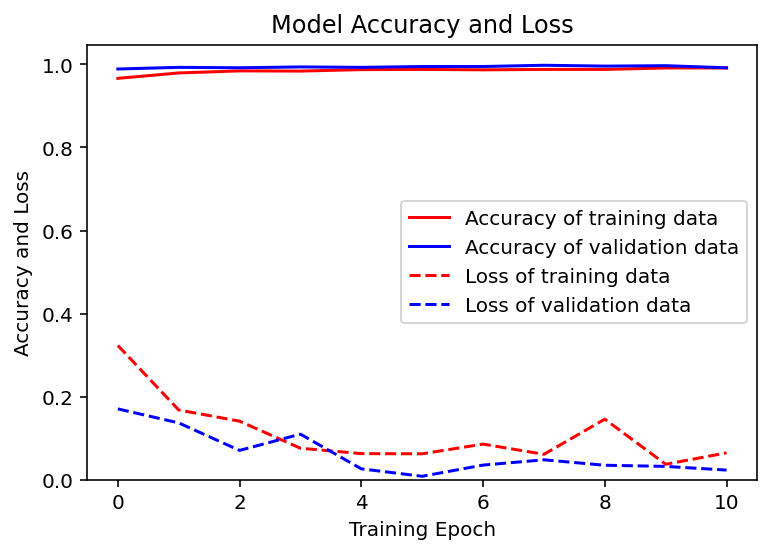

In [ ]:
show_4_graphs(history)

## 성능이 더 개선되었다.

## 요약
- 전이학습 중 분류기 재학습 방식 소개
- 전이학습 중 미세조정 방식 소개

## 강아지 사진 500 장에 대한 검증과 오분류된 사진 보기

### 이미지 전처리 함수

In [11]:
def process_images(folder, size):
  images = []
  processed_images = []
  
  files = os.listdir(folder)
  
  for file in files:
    image = mpimg.imread(os.path.join(folder, file))
    if image is not None:
        rescaled = cv2.resize(image, (size, size))/255.0
        images.append(image)
        processed_images.append(rescaled)
        
  return files, images, np.array(processed_images)

In [12]:
import cv2
# 검증할 이미지가 있는 폴더
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

folder = validation_dogs_dir

files, images, processed_images = process_images(folder, image_size)
predictions = model.predict(processed_images)

files[:5]

['dog.2232.jpg',
 'dog.2416.jpg',
 'dog.2062.jpg',
 'dog.2402.jpg',
 'dog.2078.jpg']

In [13]:
processed_images.shape

(500, 299, 299, 3)

### 예측결과 보기 (고양이: 0, 강아지: 1)

In [14]:
y_pred_proba = model.predict(processed_images)
y_pred = (y_pred_proba.ravel() > 0.5)*1
list(y_pred)[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [15]:
y_pred_proba

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999332e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999976e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.000000

## 오분류된 샘플 보기

In [16]:
wrong_index = [i for i, x in enumerate(list(y_pred)) if x == 0]
print(len(wrong_index))
wrong_index[:5]

3


[50, 69, 208]

In [35]:
def show_N_images(images, index_to_see, files, N_max=5):
  N = min(len(index_to_see), N_max)
  plt.figure(figsize=(12,5))
  for i in range(N):
     ix = index_to_see[i]
     plt.subplot(1, N, i + 1)
     plt.axis('off')
     plt.title(files[ix])
     plt.imshow(cv2.cvtColor(images[ix], cv2.COLOR_BGR2RGB))

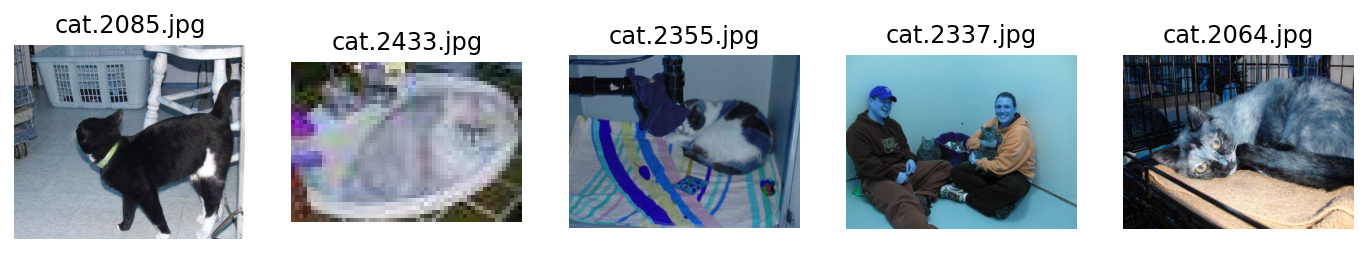

In [38]:
show_N_images(images, wrong_index,files,5)

## 고양이 사진 500장에 대한 검증과 강아지로 오분류된 샘플 보기

In [20]:
folder = validation_cats_dir
files, images, processed_images = process_images(folder, image_size)
predictions = model.predict(processed_images)

In [21]:
y_pred_proba = model.predict(processed_images)
y_pred = (y_pred_proba.ravel() > 0.5)*1
list(y_pred)[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
wrong_index = [i for i, x in enumerate(list(y_pred)) if x == 1]
print(len(wrong_index))
wrong_index[:5]

5


[35, 87, 246, 412, 455]

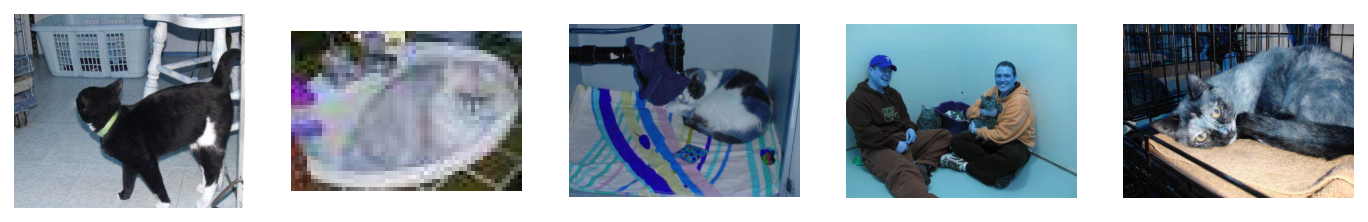

In [25]:
show_N_images(images, wrong_index,files)